# 1. Finding Similar Costumers

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import random
from tqdm import tqdm
import pickle
from datetime import datetime
from collections import Counter

In [19]:
import adm4

### 1.1 Set up the data


First of all let's import the dataset and have a look at it:

In [13]:
data = pd.read_csv('bank_transactions.csv')
data.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


Let's see how many NaN values we have for each variable:

In [14]:
data.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Since we have to look for similarity we think that NaN values are useless and so we can drop them:

In [15]:
data.dropna(inplace=True)

We can notice that in the dataframe we have that some CustomerID are present more than once:

In [16]:
data.CustomerID.is_unique

False

This means that for these customers we have more than 1 transaction in the dataframe. Since later we want to find similarity between customers we think that we should group by CustomerID in order to have unique values in the column ***CustomerID***.   
Grouping by the ID we'll create some new columns such as: 
- Most_common_location: in which we'll store the most common location between all the transactions for each customer;
- Average_transaction_amount: in which we'll store the average of all the transaction amount for each customer;
- Customer_age
- LastAccountBalance: in which we store the last Balance recorded for each customer

These columns are also the ones that we'll use to compare customers.

We've created a function that given the dataframe data will group rows by CustomerId and it will creat the columns we've talked about above.    
You can find the function  in the file adm4.py:

In [20]:
data = grouping(data)

Let's have a look at the new dataframe:

In [163]:
data.head(5)

,CustomerID,Average_transaction_amount,Most_common_location,LastAccountBalance,CustomerAge
1,C1010012,1499.0,MUMBAI,24204.49,28
2,C1010014,727.5,MUMBAI,161848.76,31
3,C1010018,30.0,CHAMPARAN,496.18,33
4,C1010024,5000.0,KOLKATA,87058.65,57
5,C1010028,557.0,DELHI,296828.37,34


Since we have to compute a minhash algorithm we think that the proper variables to work with are categorical ones.  
For that reason from the dataframe data we'll work with just some columns:

In [164]:
data = data[["CustomerID","Average_transaction_amount","Most_common_location","LastAccountBalance","CustomerAge"]]
data.dropna(inplace=True)

Starting from these variables we'll create categorical variables.   
In particular we'll create 3  categorical variables using ***Average_transaction_amount***, ***CustomerAge*** and ***LastAccountBalance***.

**Average_transaction_amount**:

Our idea is to create a new variable called ***Class_transaction*** that can take values in *[1_Class_transaction, ..., 10_Class_transaction]*.  
We'll take the maximum and minimum values of Average_transaction_amount and we'll divide max-min for 10. So that we obtain 10 intervals of the same length.   
i_Class_transaction means that that customer has an Average_transaction_amount in the class i.

In order to create this new column we use a function CLASSES that you can find in adm4.py.

In [165]:
df = classes(data,data,"Average_transaction_amount","Class_transaction","Average_transaction_amount",10)

**CustomerAge**

We now do the same thing with ***CustomerAge***.

Even in this case we use the function classes but with different parameters.

In [166]:
df = classes(data,df,"CustomerAge","Class_age","CustomerAge",10)

**LastAccountBalance**

As we can see the difference between the maximum value and minimum value of LastAccountBalance is large.   
For this reason we've thought that in this case it was better to create only 4 classes with different lengths.

In [167]:
df.LastAccountBalance.max()-df.LastAccountBalance.min()

115035495.1

In [168]:
df["Class_income"]=0
df.loc[(df["LastAccountBalance"] >= 10000) & (df["LastAccountBalance"] < 100000),"Class_income"]=1
df.loc[(df["LastAccountBalance"] >= 100000) & (df["LastAccountBalance"] < 1000000),"Class_income"]=2
df.loc[(df["LastAccountBalance"] >= 1000000),"Class_income"]=3

Let's have a look at the new columns:

In [169]:
df.head(5)

,CustomerID,Average_transaction_amount,Most_common_location,LastAccountBalance,CustomerAge,Class_transaction,Class_age,Class_income
1,C1010012,1499.0,MUMBAI,24204.49,28,1_Class_transaction,1_Class_age,1
2,C1010014,727.5,MUMBAI,161848.76,31,1_Class_transaction,1_Class_age,2
3,C1010018,30.0,CHAMPARAN,496.18,33,1_Class_transaction,2_Class_age,0
4,C1010024,5000.0,KOLKATA,87058.65,57,1_Class_transaction,4_Class_age,1
5,C1010028,557.0,DELHI,296828.37,34,1_Class_transaction,2_Class_age,2


We can now extract from the dataframe just the column we're interested in.   
In particular: ***CustomerID***, ***Most_common_location***, ***Class_transaction*** and ***Class_age***.

In [170]:
df = df[["CustomerID","Most_common_location","Class_income","Class_transaction","Class_age"]]

In [171]:
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)

Have a look at the shape and the first rows of the final dataframe.

In [172]:
df.shape

(717241, 5)

In [173]:
df.head(10)

,CustomerID,Most_common_location,Class_income,Class_transaction,Class_age
0,C1010012,MUMBAI,1,1_Class_transaction,1_Class_age
1,C1010014,MUMBAI,2,1_Class_transaction,1_Class_age
2,C1010018,CHAMPARAN,0,1_Class_transaction,2_Class_age
3,C1010024,KOLKATA,1,1_Class_transaction,4_Class_age
4,C1010028,DELHI,2,1_Class_transaction,2_Class_age
5,C1010036,GURGAON,2,1_Class_transaction,1_Class_age
6,C1010037,BANGALORE,1,1_Class_transaction,2_Class_age
7,C1010038,LOHIT,0,1_Class_transaction,1_Class_age
8,C1010039,CHANDIGARH,1,1_Class_transaction,1_Class_age
9,C1010045,AHMEDABAD,0,1_Class_transaction,2_Class_age


### 1.2 Fingerprint hashing

##### STARTING MATRIX

First of all we want to crate a sparse matrix ***M*** with all the values equal to 1 or 0.   
    Each column will represent a Customer_ID and every row will represent an unique value that a column can assume.   
    For example, looking at the first row of our dataset, the matrix M will have a 1 when the index of the row correspond to 'MUMBAI' and the index of the column corresponds to 'C1010012' and similarly with the other 3 features of the first customer.

In order to do this we'll use the transformer OneHotEncoder from the library sklearn.  
For this reason we need to store in an array **X** a number of sublists equals to number of Customer_ID such that every sublist contains all the features that its Customer_ID has.

In [174]:
# Setting an empy list in which we can store a sublist for each customer with all his corresponding values
X = []
for i in df.index:
    X.append([str(df['Most_common_location'][i]),str(df['Class_income'][i]),str(df['Class_transaction'][i]),str(df['Class_age'][i])])

# transform X in a numpay array
X = np.array(X)

We can now pass to the transformer the array X that will compute automatically the matrix we're interested in.

In [175]:
enc = OneHotEncoder(handle_unknown='ignore',dtype=np.int8)
enc.fit(X)
X = enc.transform(X).toarray()

As we can see from the outup of the next cell, the matrix we obtain has the number of column and rows inverted with respect to what we want:

In [176]:
print(X.shape)

# let's even check if the sum of the unique values in the columns of our dataframe correspons to number of columns of X
print(df.Most_common_location.nunique()+df.Class_income.nunique()+df.Class_transaction.nunique()+df.Class_age.nunique())

(717241, 7628)
7628


Before computing the transpose of X we want to know how our unique values have been 'stored' along rows of X.    
We can do that with **get_feature_names_out**

In [177]:
variables = enc.get_feature_names_out(['','','',''])
variables

array(['_(154) BHASKOLA FARIDABAD', '_(BENAKA MDTS) BANGALORE',
       '_(DT) HOSUR', ..., '_7_Class_age', '_8_Class_age', '_9_Class_age'],
      dtype=object)

We can notice that this code will save a list of all the unique values with a '_' before and they are in the same order of how they appear in the matrix X.

We can now compute the transpose of X in order to finally get the matrix we want:

In [178]:
X = np.transpose(X, axes=None)
print(X.shape)

(7628, 717241)


##### SIGNATURES MATRIX

Starting from the matrix ***M*** we want now to create our ***Signature matrix***.  
In order to this we should create random permutation of the rows of X. We think that a more practical way to do this is permuting only the index of the rows and do that using random hash functions.   
In particular we'll use hush functions like: $h(x) = ax+b$ $ mod$ $ c$. 
We'll evaluate this function on x that is the index of a given row.   
$a$ and $b$ will be random number between 0 and the number of rows of X and $c$ is a prime number greater than the number of rows of X.   
We'll create a number of this functions equal to the number of permutations we want to compute on the rows of X and for each of them we'll apply the function to all the indeces of the rows.

In [179]:
# number of hash functions to generate
nHash = 20

# number of rows of X
max_shingle = X.shape[0]

# next prime number of max_shingle
max_prime = 7639

# generating coefficients of the hash functions 
# you can find the function random_hash in adm4.py
a_list = random_hash(nHash,max_shingle)
b_list = random_hash(nHash,max_shingle)

In [180]:
#initializing the signatures matrix with infinity values 
signatures = np.ones((nHash,X.shape[1])) * np.inf
signatures.shape

(20, 717241)

Computing hash values and minimizing signatures values.   
In the next cell we use the function HASH_FUNCTION in order to compute an hush function on a given x. You can find that function in adm4.py.

In [181]:
for row in tqdm(range(X.shape[0])):
    ones = np.where(X[row]==1)
    for index_ones in ones[0]:
        for i in range(nHash):
                signatures[i][index_ones] = min(hash_function(a_list[i],b_list[i],row,max_prime),signatures[i][index_ones])

100%|██████████████████████████████████████████████████████████████████████████████| 7628/7628 [01:58<00:00, 64.48it/s]


##### LSH

Given the signatures matrix we divide its rows in ***b*** bands each of ***r*** rows.   
Then for each band we will map similar pairs customers (they have equals values in that band) in the same bucket.

We could set different threshold choosing different values for r and b.    
Let's say that the threshold t is approximately equals to $(\frac{1}{b})^{\frac{1}{r}}$ and this mean that with high probability we'll find candidates with jaccard similarity greater or equal to t.

We've tested the algorithm with r = 4 and b = 5. In this case we have that t=0.667

In [182]:
r = 4
b = int(nHash/r)

***buckets*** is a dictionary such that its keys are the number of the bands and its values are dictionaries.   
For example the dictionary of the first band will have as keys the unique signature values of customers in that band and as values a list with all the indeces of customers that have that signature values.  So that all the customers in the same list should be similar.   
So the structure of buckets is like:

In [183]:
# setting an empty bucket
buckets = {}

# for loop for each band
for i in tqdm(range(0,signatures.shape[0],r)):
    if i%r == 0:
        # setting a temporary empty dictionary for the given band 
        temp_bucket = {}
    # for each costumers
    for j in range(signatures.shape[1]):
        sign = [str(signatures[l][j]) for l in range(i, i+r)]
        
        if set_signature_combination(sign) in temp_bucket.keys():
            temp_bucket[set_signature_combination(sign)].append(j)
        else :
            temp_bucket[set_signature_combination(sign)] = []
            temp_bucket[set_signature_combination(sign)].append(j)
    # we assign temp_bucket as a value of buckets
    if i%r == 0 :
        buckets[str(int(i/r))] = temp_bucket 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


We can see that at the end we have that the length of bucjets is equal to number of the bands:

In [184]:
print(len(buckets))
buckets.keys()

5


dict_keys(['0', '1', '2', '3', '4'])

## 1.3 Locality Sensitive Hashing

Let's now test our algorithm with some Customers.   
In order to do this we need to reed the ***query_users.csv*** file:

In [185]:
query = pd.read_csv('query_users.csv')

Let's have a look at this customers:

In [186]:
query.head(5)

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


For our algorithm we need just a few of this columns and in particular: ***CustLocation***, ***CustAccountBalance*** and ***TransactionAmount (INR)***.

In [187]:
query = query[['CustLocation','CustAccountBalance','TransactionAmount (INR)','CustomerDOB']]

In [188]:
# dropping nan values since they are useless for our purpose
query.dropna(inplace=True)

In order to use the algortihm we have to prepare the dataset in the right format.

First we compute the age of each customer:

In [189]:
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)

#Create a new column 
query['CustomerAge'] = (( pd.to_datetime('today') - query.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

#Change the type of the column as integer
query['CustomerAge'] = query['CustomerAge'].astype(int)

In order to create the columns ***Class_transaction*** and ***Class_age*** we need the orignal dataset because we want that the length of each classes is equal to the length of the classes of the original dataset.  
For this reason when we call the function CLASSES we'll pass at the function also the original dataset data.

Creating ***Class_transaction*** column for query:

In [190]:
query = classes(data,query,"TransactionAmount (INR)","Class_transaction","Average_transaction_amount",10)

Creating ***Class_age*** column for query:

In [191]:
query = classes(data,query,"CustomerAge","Class_age","CustomerAge",10)

Creating ***Class_income*** column using the same intervals used for the original dataset:

In [192]:
query["Class_income"]=0
query.loc[(query["CustAccountBalance"] >= 10000) & (query["CustAccountBalance"] < 100000),"Class_income"]=1
query.loc[(query["CustAccountBalance"] >= 100000) & (query["CustAccountBalance"] < 1000000),"Class_income"]=2
query.loc[(query["CustAccountBalance"] >= 1000000),"Class_income"]=3

We can now select just the columns we're interested in:

In [193]:
query = query[["CustLocation","Class_transaction", "Class_age", "Class_income" ]]

Have a look at the processed data:

In [194]:
query.head(5)

,CustLocation,Class_transaction,Class_age,Class_income
0,DELHI,1_Class_transaction,3_Class_age,1
1,PANCHKULA,1_Class_transaction,1_Class_age,0
2,PATNA,1_Class_transaction,1_Class_age,0
3,CHENNAI,1_Class_transaction,2_Class_age,1
4,GURGAON,1_Class_transaction,1_Class_age,1


In order to find the similar customers to the ones in the query we need to compute again: 
- starting matrix ***X_query***
- signatures matrix ***signatures_query*** 

We will use the exactly same hush functions as before and the rows of X_query will be ordered in the same way of X.

In [195]:
# Setting an empy list in which we can store a sublist for each customer with all his corresponding values
X_query = []
for i in query.index:
    X_query.append([str(query['CustLocation'][i]),str(query['Class_income'][i]),str(query['Class_transaction'][i]),str(query['Class_age'][i])])

# transform X in a numpay array
X_query = np.array(X_query)

# computing the starting matrix using the same transformer as before
X_query = enc.transform(X_query).toarray()

# computing the transpose of X_query
X_query = np.transpose(X_query, axes=None)

# have a look at the shape
print(X_query.shape)


(7628, 50)


In [196]:
# computing signatures matrix

signatures_query = np.ones((nHash,X_query.shape[1])) * np.inf

for row in tqdm(range(X_query.shape[0])):
    ones = np.where(X_query[row]==1)
    for index_ones in ones[0]:
        for i in range(nHash):
                signatures_query[i][index_ones] = min(hash_function(a_list[i],b_list[i],row,max_prime),signatures_query[i][index_ones])

# have a look at the shape
signatures_query.shape

100%|██████████████████████████████████████████████████████████████████████████| 7628/7628 [00:00<00:00, 223332.39it/s]


(20, 50)

As before we divide the signatures matrix in b bands of r rows each.   
For each customer in the query we find all its similar customers of the orginal dataset and we collect all their indeces in a list.   
***similar_query*** will be a list of 50 values such that each of them is a list containg all similar customers to a query customer.

In [197]:
similar_query = []
for j in tqdm(range(signatures_query.shape[1])):
    similar = set()
    for i in range(0,signatures_query.shape[0],r):
        temp_bucket = buckets[str(int(i%r))]
        sign = [str(signatures_query[l][j]) for l in range(i, i+r)]
            
        if set_signature_combination(sign) in temp_bucket.keys():
                similar.update(temp_bucket[set_signature_combination(sign)])
        else :
            continue
    similar_query.append(list(similar))     

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 597.92it/s]


Now for each query customers we'll compute the jaccard similarity with all its similar customers we've found and we'll create a new column ***Scores*** that will represent the maximum jaccard similarity.   
Since we are working with just 4 features there will be with a high probability at least one query customer that has an equal customer in the original dataset.   
So our idea is to find for each query cutomer that has a score equals to 1 the number of times we have a jaccard similarity equals to 1 with its similar.  
Then we'll create a new column called ***Percentage_of_equals*** in which we'll store the precentage of equals we've found to that customer between its similar.

In [198]:
scores = []
number_of_equal = []

In the nex cell we use the function JACCARD_SIM that computes the jaccard similarity between two given customers. You can find that function in adm4.py.

In [199]:
for i in tqdm(range(len(similar_query))):
    count = 0
    if similar_query[i] != []:
        similar = similar_query[i]
        max_jaccard = 0
        for j in range(len(similar)):
            jaccard = jaccard_sim(similar[j],query,i,df)
            if jaccard == 1.0:
                count += 1
            if jaccard>max_jaccard:
                max_jaccard = jaccard
    else:
        scores.append(0)
        number_of_equal.append(0)
        continue
    
    
    number_of_equal.append(count)
    scores.append(max_jaccard)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.14it/s]


Have a look at the unique values of scores we've found:

In [200]:
print(set(scores))

{0.6, 1.0, 0}


Adding the two new columns:

In [201]:
query = query.assign(Scores = scores)
number_of_equal = [(i/df.shape[0])*100 for i in number_of_equal]
query = query.assign(Percentage_of_equals = number_of_equal)

We can now select just the query customers with score equals to 1 and sort the new dataframe by ***Percentage_of_equals***.

In [202]:
final_query = query.loc[query['Scores']==1.0]
final_query = final_query.sort_values(by = 'Percentage_of_equals', ascending = False)

Final output for b = 5, r = 4

In [203]:
final_query.head(10)

,CustLocation,Class_transaction,Class_age,Class_income,Scores,Percentage_of_equals
27,MUMBAI,1_Class_transaction,2_Class_age,1,1.0,2.495256
38,NEW DELHI,1_Class_transaction,2_Class_age,1,1.0,2.092463
49,DELHI,1_Class_transaction,2_Class_age,1,1.0,1.651328
11,BANGALORE,1_Class_transaction,2_Class_age,0,1.0,1.624837
10,BANGALORE,1_Class_transaction,2_Class_age,0,1.0,1.624837
37,BANGALORE,1_Class_transaction,2_Class_age,0,1.0,1.624837
43,NEW DELHI,1_Class_transaction,2_Class_age,0,1.0,1.316294
16,MUMBAI,1_Class_transaction,1_Class_age,0,1.0,0.964669
36,NEW DELHI,1_Class_transaction,2_Class_age,2,1.0,0.765851
33,NEW DELHI,1_Class_transaction,2_Class_age,2,1.0,0.765851


As we can see we've found that in the query (with categorical variables) there are different customers that have at least 1 customer in the dataset that is equal.   
We expected this result since we looked for similarity using only 4 variables and since the original dataset contains a lot of customers.  
But we can even notice that the customer 28 (since indeces start from 0) is the one with more equal customers in the dataset so for how we've looked for similarity we can say that it is the most similar one.

This mean that in the original dataset the most frequent customer has features as:   
- most frequent location = Mumbai
- average transaction between 0 and 312006
- age between 20 and 30
- balance between  10000 and 100000

# 2.1 Getting your data + feature engineering

In [15]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
from collections import Counter
pd.options.mode.chained_assignment = None  # default='warn'

df=pd.read_csv("bank_transactions.csv")
inizio=pd.to_datetime('today')

In [16]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


## Na analysis

In [17]:
df.shape

(1048567, 9)

In [18]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Since we have to create new variables starting with the ones that we have, we think that rows with NA values
are useless.
Also we can notice that rows which contain NA values are in a small number compared to the shape of the dataframe.
According to these  we delete them.

In [19]:
df.dropna(inplace=True)
df.shape

(1041614, 9)

## Change the data type

In [20]:
df[["CustomerDOB","TransactionDate","TransactionTime"]].head(1)

,CustomerDOB,TransactionDate,TransactionTime
0,10/1/94,2/8/16,143207


Since there are variables with date and times not in the proper format we will change the type of those variables.

In [21]:
df.CustomerDOB=pd.to_datetime(df.CustomerDOB)
df.TransactionDate=pd.to_datetime(df.TransactionDate)

In [22]:
df[["CustomerDOB","TransactionDate"]].head(1)

,CustomerDOB,TransactionDate
0,1994-10-01,2016-02-08


In [23]:
df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S').time())

Now the time variables seems to be correct.

In [24]:
df[["CustomerDOB","TransactionDate","TransactionTime"]].head(1)

,CustomerDOB,TransactionDate,TransactionTime
0,1994-10-01,2016-02-08,14:32:07


## Delete costumer that results born in 1800

In [25]:
df.drop(df[df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
df.shape

(985322, 9)

There was 56292 transactions belonging to customer born in 1800, or registered by error born in 1800.

### Fixing the millenium bug

In [26]:
df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

### Create new variables


## Grouping by customer ID
Each row will be a different client.
There are some issue with gender's variable so we are escluding it for now.

In [139]:
customer=df.groupby("CustomerID").sum()
customer=customer.rename(columns={"TransactionAmount (INR)":"TOT TransactionAmount (INR)"})
customer.drop(columns=["CustAccountBalance"],inplace=True)
customer.shape

(839081, 1)

We have deleted because is a features that must not be summed.

### Create  "Number of transactions"

In [140]:
number_transaction=pd.DataFrame(df.groupby("CustomerID").count().TransactionID)
number_transaction=number_transaction.rename(columns={"TransactionID":"Number_of_transaction"})
customer=pd.merge(customer,number_transaction,on="CustomerID")
customer.shape

(839081, 2)

### Create  "Number of transactions" bigger than 100 USD

In [141]:
number_transaction=pd.DataFrame(df[df["TransactionAmount (INR)"]> 100].groupby("CustomerID").count().TransactionID)
number_transaction=number_transaction.rename(columns={"TransactionID":"Number_of_transaction_100"})
customer=pd.merge(customer,number_transaction,on="CustomerID", how='left')

#Put 0 instead of NaN
customer.Number_of_transaction_100=customer.Number_of_transaction_100.fillna(0)
customer.shape

(839081, 3)

### Average of the transactions

In [142]:
means=pd.DataFrame(df.groupby("CustomerID")["TransactionAmount (INR)"].mean())
means=means.rename(columns={"TransactionAmount (INR)":"Average_transaction_amount"})
customer=pd.merge(customer,means,on="CustomerID")
customer.shape

(839081, 4)

### Average balance

In [143]:
average=pd.DataFrame(df.groupby("CustomerID")["CustAccountBalance"].mean())
average=average.rename(columns={"CustAccountBalance":"Average_amount_balance"})
customer=pd.merge(customer,average,on="CustomerID")
customer.shape

(839081, 5)

### Utilisation 
Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).

In [144]:
df['Utilisation'] = df['CustAccountBalance'] - df['TransactionAmount (INR)']

average=pd.DataFrame(df.groupby("CustomerID")['Utilisation'].mean())
average=average.rename(columns={"Utilisation":"Average_Utilisation"})
customer=pd.merge(customer,average,on="CustomerID")
customer.shape

(839081, 6)

### Gender of the customer

In [145]:
def different_gender(x):
    
    lista=list(x)
    
    if lista.count("M")==len(lista):
        return "M"
    elif lista.count("F")==len(lista):
        return "F"
    else:
        return "FM"
    
data=df[["CustomerID","CustGender"]]

#Create a new variable
data["Account_gender"]=data.groupby('CustomerID')["CustGender"].transform(lambda x: different_gender(x))

#We drop duplicates keeping the last value (the most recent)
data=data.drop_duplicates(subset=["CustomerID"])


#Merging
customer=pd.merge(customer,data[["CustomerID","Account_gender"]],on="CustomerID")
customer.shape

(839081, 8)

### Most frequent location of the customer

In [28]:
def most_common(x):

    #Counter
    occurence_count = Counter(list(x))
    
    #Frequency of most popular place
    frequency=occurence_count.most_common(1)[0][1]
    
    #Check if the places is the most popular
    #If there is a draw None will be returned
    
    other_frequency=list(occurence_count.values()) #list of all frequency
    
    if other_frequency.count(frequency) > 1:
        return None
    
    
    return occurence_count.most_common(1)[0][0]

def percentage(x):
    #Counter
    occurence_count = Counter(list(x))
    
    #Frequency of most popular place
    frequency=occurence_count.most_common(1)[0][1]
    
    #Check if the places is the most popular
    
    other_frequency=list(occurence_count.values())
    
    if other_frequency.count(frequency) > 1:
        return None
    else:
    
        #Evaluate the percentage of the transaction maded in the most common place.
        perc=round(frequency/len(x)*100,2)
    
        return perc

In [147]:
#We create a subset of the dataset.
data=df[['CustomerID','CustLocation']]

#Create a new variable
data['Most_common_location'] = data.groupby('CustomerID')['CustLocation'].transform(lambda x: most_common(x))

#We drop the duplicates in order to avoid error during the merging. That's the reason of the creation of the subset.
data.drop_duplicates(subset=['CustomerID'],inplace=True)

#Merging data
customer=pd.merge(customer,data[["CustomerID",'Most_common_location']],on="CustomerID")

customer.shape

/var/folders/j4/9fk3st2d30g22vff83pj6cnw0000gn/T/ipykernel_1180/1914737971.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data['Most_common_location'] = data.groupby('CustomerID')['CustLocation'].transform(lambda x: most_common(x))


(839081, 9)

## Create other 20 features

### CustomerAge

In [148]:
#We create a subset of the dataset.
data=df[["CustomerID","CustomerDOB"]]

#We drop the duplicates in order to avoid error during the merging. That's the reason of the creation of the subset.
data.drop_duplicates(subset=['CustomerID'],inplace=True)

#Create a new variable
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

#Change the type of the column
data['CustomerAge'] = data['CustomerAge'].astype(int)

#Merging
customer=pd.merge(customer,data[["CustomerID",'CustomerAge']],on="CustomerID")

customer.shape

(839081, 10)

### Binary for major costumer and Age_in_2016
The feature "Major" will be 1 is the costumer was major in 2016, 0 if the costumer was under 18 years old in 2016.


In [149]:
#Create a new variable
data['Age_in_2016'] = (( pd.to_datetime('2016-12-31') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

data['Major']=1
data.loc[data["Age_in_2016"] <18,'Major']=0

#Change the type of the column
data["Age_in_2016"] = data["Age_in_2016"].astype(int)

#Merging
customer=pd.merge(customer,data[["CustomerID","Age_in_2016",'Major']],on="CustomerID")

customer.shape

(839081, 12)

In [150]:
customer.to_pickle("/Users/mattia/Desktop/ADM(Aris)/HM4/customer.pkl")

### Old customer
The feature "OLD" will be 1 is the costumer in 2016 was 70 years old or more.

In [151]:
#Create a new variable
data['Old']=0
data.loc[data["Age_in_2016"] >= 70,'Old']=1

#Merging
customer=pd.merge(customer,data[["CustomerID",'Old']],on="CustomerID")

customer.shape

(839081, 13)

### Minimum Transaction

In [152]:
minimi=pd.DataFrame(df.groupby(['CustomerID'], sort=False)['TransactionAmount (INR)'].min())
minimi=minimi.rename(columns={'TransactionAmount (INR)':"Min Transaction"})
minimi=minimi.reset_index()

#Merging
customer=pd.merge(customer,minimi[["CustomerID","Min Transaction"]],on="CustomerID")

customer.shape

(839081, 14)

### Maximum Transaction

In [153]:
minimi=pd.DataFrame(df.groupby(['CustomerID'], sort=False)['TransactionAmount (INR)'].max())
minimi=minimi.rename(columns={'TransactionAmount (INR)':"Max Transaction"})
minimi=minimi.reset_index()

#Merging
customer=pd.merge(customer,minimi[["CustomerID","Max Transaction"]],on="CustomerID")

customer.shape

(839081, 15)

### Last account balance
We take as last account balance the account balance  of most recent transaction.

In [154]:
#We sort the df dataset in descending order. We save this new  dataset with the name "data"
data=df.sort_values("TransactionDate")

#We drop duplicates keeping the last value (the most recent)
data=data.drop_duplicates(subset=["CustomerID"],keep="last")
data=data.rename(columns={'CustAccountBalance':"LastAccountBalance"})

#Merging
customer=pd.merge(customer,data[["CustomerID","LastAccountBalance"]],on="CustomerID")
customer.shape

(839081, 16)

### Account balance range

Class , range:
- Lower 0, [0,10000)
- Medium 1, [10000,100000)
- High 2,   [100000,1000000)
- Very High 3,[1000000,inf)

In [155]:
customer["Class_income"]=0
customer.loc[(customer["LastAccountBalance"] >= 10000) & (customer["LastAccountBalance"] < 100000),"Class_income"]=1
customer.loc[(customer["LastAccountBalance"] >= 100000) & (customer["LastAccountBalance"] < 1000000),"Class_income"]=2
customer.loc[(customer["LastAccountBalance"] >= 1000000),"Class_income"]=3
customer.shape

(839081, 17)

### Concentrazione 
This features says for each customer of much he have of the total of money in circulation.

In [156]:
tot=data.LastAccountBalance.sum()
customer["Percentual_of_total"]= ((customer["LastAccountBalance"]/tot)*100)#.apply(lambda x: '%.2f' % x)
customer["Percentual_of_total"]=customer["Percentual_of_total"].astype(float)
customer.shape

(839081, 18)

### Top 100
The feature "Top" will be 1 if the customer's LastAccountBalance is in the top 100.

In [157]:
#Extract the "CustomerID" of the top 100 customers
top100=list(data.sort_values("LastAccountBalance",ascending=False).head(100)["CustomerID"])

customer["Top100"]=0
customer.loc[(customer["CustomerID"].isin(top100)),"Top100"]=1
customer.shape

(839081, 19)

### Most frequent hour of transaction

In [29]:
df["Hour"]=df.TransactionTime.apply(lambda x: x.strftime("%H"))

data=df[["CustomerID","Hour"]]

#Create a new variable
data['Most_common_hour'] = data.groupby('CustomerID')["Hour"].transform(lambda x: most_common(x))

#We drop duplicates keeping the last value (the most recent)
data=data.drop_duplicates(subset=["CustomerID"])


#Merging
customer=pd.merge(customer,data[["CustomerID",'Most_common_hour']],on="CustomerID")
customer.shape

/var/folders/j4/9fk3st2d30g22vff83pj6cnw0000gn/T/ipykernel_15499/3236127050.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data['Most_common_hour'] = data.groupby('CustomerID')["Hour"].transform(lambda x: most_common(x))


(839081, 27)

### Percentage of transactions in the most common hour

In [30]:
df["Hour"]=df.TransactionTime.apply(lambda x: x.strftime("%H"))

data=df[["CustomerID","Hour"]]


data['Percentage_most_common_hour'] = data.groupby('CustomerID')["Hour"].transform(lambda x: percentage(x))

#We drop duplicates keeping the last value (the most recent)
data=data.drop_duplicates(subset=["CustomerID"])


#Merging
customer=pd.merge(customer,data[["CustomerID",'Percentage_most_common_hour']],on="CustomerID")
customer.shape

/var/folders/j4/9fk3st2d30g22vff83pj6cnw0000gn/T/ipykernel_15499/2011114929.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data['Percentage_most_common_hour'] = data.groupby('CustomerID')["Hour"].transform(lambda x: percentage(x))


(839081, 28)

### Most common day of the week

In [160]:
df["Day"]=df.TransactionTime.apply(lambda x: x.strftime("%A"))

data=df[["CustomerID","Day"]]

#Create a new variable
data['Most_common_day'] = data.groupby('CustomerID')["Day"].transform(lambda x: most_common(x))

#We drop duplicates keeping the last value (the most recent)
data=data.drop_duplicates(subset=["CustomerID"])


#Merging
customer=pd.merge(customer,data[["CustomerID",'Most_common_day']],on="CustomerID")
customer.shape

(839081, 22)

### Percentage of transactions in the most common day

In [161]:
#Create a new variable
data['Percentage_most_common_day'] = data.groupby('CustomerID')["Day"].transform(lambda x: percentage(x))

#We drop duplicates keeping the last value (the most recent)
data=data.drop_duplicates(subset=["CustomerID"])


#Merging
customer=pd.merge(customer,data[["CustomerID",'Percentage_most_common_day']],on="CustomerID")
customer.shape

(839081, 23)

### Percentile of LastAccountBalance

inizio22=pd.to_datetime('today')
customer["LastAccountBalance_percentile"]=customer.LastAccountBalance.apply(lambda x:round(stats.percentileofscore(customer['LastAccountBalance'],x , kind='mean'),2))
#customer.shape
pd.to_datetime('today')-inizio22

#Too much time to compute

### First transaction
This features describe the date of the first transaction.

In [162]:
#We sort the df dataset in descending order. We save this new  dataset with the name "data"
data=df[["CustomerID","TransactionDate"]].sort_values("TransactionDate",ascending=True)

#Rename feature
data=data.rename(columns={"TransactionDate":"FirstTransactionDate"})

#We drop duplicates keeping the last value (the most recent)
data.drop_duplicates(subset=["CustomerID"],keep="first",inplace=True)

#Merging
customer=pd.merge(customer,data[["CustomerID","FirstTransactionDate"]],on="CustomerID")
customer.shape

(839081, 24)

### Last transaction
This features describe the date of the last transaction.

In [163]:
#We sort the df dataset in descending order. We save this new  dataset with the name "data"
data=df[["CustomerID","TransactionDate"]].sort_values("TransactionDate",ascending=True)

#Rename feature
data=data.rename(columns={"TransactionDate":"LastTransactionDate"})

#We drop duplicates keeping the last value (the most recent)
data.drop_duplicates(subset=["CustomerID"],keep="last",inplace=True)

#Merging
customer=pd.merge(customer,data[["CustomerID","LastTransactionDate"]],on="CustomerID")
customer.shape

(839081, 25)

### Percentile of age

inizio25=pd.to_datetime('today')
customer["LastAccountBalance_percentile"]=customer.CustomerAge.apply(lambda x:round(stats.percentileofscore(customer.CustomerAge,x , kind='mean'),2))
#customer.shape
pd.to_datetime('today')-inizio25  
##Too much time to compute

### Percentage of transactions in the most_common_location 

In [164]:
#We create a subset of the dataset.
data=df[["CustomerID","CustLocation"]]


#Create a new variable
data['Percentage_most_common_location'] = data.groupby('CustomerID')['CustLocation'].transform(lambda x: percentage(x))

#We drop the duplicates in order to avoid error during the merging. That's the reason of the creation of the subset.
data.drop_duplicates(subset=['CustomerID'],inplace=True)

#Merging data
customer=pd.merge(customer,data[["CustomerID",'Percentage_most_common_location']],on="CustomerID")

customer.shape

/var/folders/j4/9fk3st2d30g22vff83pj6cnw0000gn/T/ipykernel_1180/901336727.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data['Percentage_most_common_location'] = data.groupby('CustomerID')['CustLocation'].transform(lambda x: percentage(x))


(839081, 26)

### Number_of_transaction_10000

In [165]:
number_transaction=pd.DataFrame(df[df["TransactionAmount (INR)"]> 10000].groupby("CustomerID").count().TransactionID)
number_transaction=number_transaction.rename(columns={"TransactionID":"Number_of_transaction_10000"})
customer=pd.merge(customer,number_transaction,on="CustomerID", how='left')

#Put 0 instead of NaN
customer.Number_of_transaction_10000=customer.Number_of_transaction_10000.fillna(0)
customer.shape

(839081, 27)

### Average time between transaction

In [166]:
#We create a subset of the dataset.
data=df[["CustomerID","TransactionDate"]]

#Create a function that give the mean among transaction.
def time_between_transaction(x):
    
    date=sorted(list(x))
    differenze=[]
    for i in range(1,len(date)):
        differenze.append(date[i]-date[i-1])
    
    
    return np.mean(np.array(differenze))

#Create a new variable
data["Medium_time_among_transaction"]=data.groupby('CustomerID')["TransactionDate"].transform(lambda x: time_between_transaction(x))

#We drop duplicates keeping the last value (the most recent)
data.drop_duplicates(subset=["CustomerID"],inplace=True)

#Merge
customer=pd.merge(customer,data[["CustomerID","Medium_time_among_transaction"]],on="CustomerID")

/opt/anaconda3/envs/ADM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ADM/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Export the data

In [34]:
customer.to_pickle("/Users/mattia/Desktop/ADM(Aris)/HM4/customer"+str(customer.shape[1])+".pkl")
pd.to_datetime('today')-inizio
#customer=pd.read_pickle("/Users/mattia/Desktop/ADM(Aris)/HM4/customer28.pkl")
#customer.columns
#customer.isna().sum()
#customer=customer.rename(columns={"Mean_among_transaction":"Medium_time_among_transaction"})
#customer.drop(columns=["Most_common_hour","Percentage_most_common_hour"],inplace=True)

# 2.2 Choose your features (variables)!

### Import packages and data

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
data=pd.read_pickle("/Users/mattia/Desktop/ADM(Aris)/HM4/customer28.pkl") 

## Cleaning data

Since we will work over all the features we specifiy that "CustomerID"  is non a features but is the index
of our data.

In [3]:
data.set_index('CustomerID',inplace=True)

We will reduce the dimensionality of the dataset using one of the most common and popular statistical methodology the Principal Componenent Analysis. 
Since PCA is a methodology made for quantitative data so as first thing we have to delete all the non-numeric features, or also
recoding this features as binary.  


### Delete features

In [4]:
data.isna().sum()

TOT TransactionAmount (INR)             0
Number_of_transaction                   0
Number_of_transaction_100               0
Average_transaction_amount              0
Average_amount_balance                  0
Average_Utilisation                     0
Account_gender                          0
Most_common_location               121840
CustomerAge                             0
Age_in_2016                             0
Major                                   0
Old                                     0
Min Transaction                         0
Max Transaction                         0
LastAccountBalance                      0
Class_income                            0
Percentual_of_total                     0
Top100                                  0
Most_common_day                         0
Percentage_most_common_day              0
FirstTransactionDate                    0
LastTransactionDate                     0
Percentage_most_common_location    121840
Number_of_transaction_10000       

We delete:
- "FirstTransactionDate"
- "LastTransactionDate"
- "Medium_time_among_transaction"

because they are  in datetype so not numerical.

After we delete :
- "Most_common_day" 
- "Percentage_most_common_day" 
because they are  constant.


Also we delete :
- Most_common_location
- Percentage_most_common_location
- Most_common_hour
- Percentage_most_common_hour

because for the way that are they build they contain lots of NA.

After that we delete the feature:
- CustomerAge

because we have the features Age_in_2016 that is more important.



In [5]:
columns=["FirstTransactionDate","LastTransactionDate","Most_common_day","Percentage_most_common_day",
         "Medium_time_among_transaction","Most_common_location","Percentage_most_common_location",
         "Most_common_hour","Percentage_most_common_hour","CustomerAge"]

data.drop(columns=columns,inplace=True)

In [6]:
data.isna().sum()

TOT TransactionAmount (INR)    0
Number_of_transaction          0
Number_of_transaction_100      0
Average_transaction_amount     0
Average_amount_balance         0
Average_Utilisation            0
Account_gender                 0
Age_in_2016                    0
Major                          0
Old                            0
Min Transaction                0
Max Transaction                0
LastAccountBalance             0
Class_income                   0
Percentual_of_total            0
Top100                         0
Number_of_transaction_10000    0
dtype: int64

### Re-encode gender feature
We re-encode the feature gender as three binary features.

In [7]:
data["M"]=0
data.loc[(data["Account_gender"]=="M"),"M"]=1

data["F"]=0
data.loc[(data["Account_gender"]=="F"),"F"]=1

data["FM"]=0
data.loc[(data["Account_gender"]=="FM"),"FM"]=1
columns=["Account_gender"]
data.drop(columns=columns,inplace=True)

## Standardize the data (all means of the features 0 and all the variance 1)

Different features could have different variance based on the phenomenon their represent.
Infact if we take two features as :
- weight of child
- weight of a car

Even if the features  **weight of child** is more variable than **weight of a car** is variance will be most 
probably lower because the feature **weight of a car** contain bigger numbers.


Since the PCA choose the first p component based on their variance,  we have to standardize our features in order to give to 
each feature the same starting point.  
At this point we will choose correctly the features with the highiest variance.  
This is crucial if we think that all the information that a features contain is given by is variability.  
Essentialy the variability is the information.

In [8]:
data.var().apply(lambda x: '%.2f' % x)

TOT TransactionAmount (INR)        44724740.76
Number_of_transaction                     0.19
Number_of_transaction_100                 0.31
Average_transaction_amount         36544439.03
Average_amount_balance         618192774929.38
Average_Utilisation            617708981932.97
Age_in_2016                              80.71
Major                                     0.00
Old                                       0.00
Min Transaction                    34625979.34
Max Transaction                    43926540.52
LastAccountBalance             678908688620.19
Class_income                              0.55
Percentual_of_total                       0.00
Top100                                    0.00
Number_of_transaction_10000               0.02
M                                         0.21
F                                         0.19
FM                                        0.06
dtype: object

Since the varibility is very different between the features we standardize

In [9]:
import numpy as np
# Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler

# data values
cols=data.columns

# scaler
scaler = StandardScaler()
data[cols] = scaler.fit_transform(data[cols]) #In this way we don't lose the dataframe format

## PCA

First we try to find out the correct number of pca.  
We can try to figure it out this number with the help of a graph. 

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(cols))
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=19, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

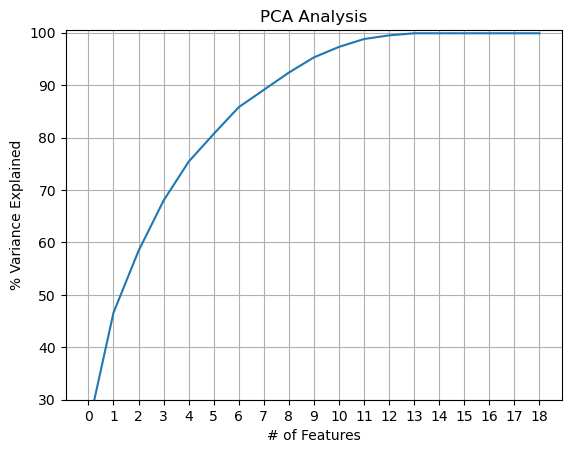

In [11]:
import matplotlib.pyplot as plt
variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var 


plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.xticks([i for i in range(0,20)])
plt.grid()
plt.plot(var)

Based on this graph we can say that the number of pca is between 3 and 13.
Of course we want to take less pca as possible so for a more correct choose we can have a look on
some pca metrics

### PCA metrics

#### Total variance explained and variance explained from each component

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca.fit(data)

total_variance_explained=pca.explained_variance_ratio_.sum()
print("Total variance explained :",total_variance_explained,"\n")
print("Variance that each component explain:",pca.explained_variance_)


Total variance explained : 0.8585167310975884 

Variance that each component explain: [4.72991515 4.12341183 2.2494352  1.82650279 1.41484466 1.00034975
 0.96737795]


Riassume the values:

- p=3 Total variance explained : 0.58 Clearly 3 pcas are not enough.
- p=4 Total variance explained : 0.68 Also 4 pcas are not enough.

The choice will be among the values  included between 5-12.
- p=5 Total variance explained  : 0.75 
- p=6 Total variance explained  : 0.80 
- p=7 Total variance explained  : 0.85 
- p=8 Total variance explained  : 0.89
- p=9 Total variance explained  : 0.92
- p=10 Total variance explained : 0.95
- ...

After the 8th component the variance explained by another pca is not increasing a lot so the choice will be 
among : 5,6,7,8.  

#### Communalities
In order to evaluate the communalities we need the factor pattern.  
Altough for now we will skip the factor pattern analysis.
Communalities shows how well a feature is represented by the p pca that
we have choosen.
So we will compare communalities between different p in order to choose.

**5 components**

In [12]:
pca = PCA(n_components=5)
pca.fit(data)

total_variance_explained=pca.explained_variance_ratio_.sum()

factor_pattern=pd.DataFrame(pca.components_,columns=cols).T

cols_to_delete=factor_pattern.columns
factor_pattern["communalities"]=factor_pattern.apply(lambda x :np.sum(np.square(x)),axis=1 )
communalities=factor_pattern.drop(columns=cols_to_delete)
communalities

#We will export the dataset in order to have a look on it.
communalities.to_csv("/Users/mattia/desktop/communalities5.csv")

**6 components**

In [13]:
pca = PCA(n_components=6)
pca.fit(data)


factor_pattern=pd.DataFrame(pca.components_,columns=cols).T

cols_to_delete=factor_pattern.columns
factor_pattern["communalities"]=factor_pattern.apply(lambda x :np.sum(np.square(x)),axis=1 )
communalities=factor_pattern.drop(columns=cols_to_delete)
communalities

,communalities
TOT TransactionAmount (INR),0.226549
Number_of_transaction,0.372592
Number_of_transaction_100,0.282345
Average_transaction_amount,0.231851
Average_amount_balance,0.209721
Average_Utilisation,0.209885
Age_in_2016,0.478643
Major,0.959678
Old,0.417703
Min Transaction,0.213690


**7 components**

In [14]:
pca = PCA(n_components=7)
pca.fit(data)


factor_pattern=pd.DataFrame(pca.components_,columns=cols).T

cols_to_delete=factor_pattern.columns
factor_pattern["communalities"]=factor_pattern.apply(lambda x :np.sum(np.square(x)),axis=1 )
communalities=factor_pattern.drop(columns=cols_to_delete)
communalities

,communalities
TOT TransactionAmount (INR),0.227473
Number_of_transaction,0.375323
Number_of_transaction_100,0.303033
Average_transaction_amount,0.232553
Average_amount_balance,0.209724
Average_Utilisation,0.209887
Age_in_2016,0.478738
Major,0.997104
Old,0.634352
Min Transaction,0.214116


In [15]:
pca = PCA(n_components=8)
pca.fit(data)


factor_pattern=pd.DataFrame(pca.components_,columns=cols).T

cols_to_delete=factor_pattern.columns
factor_pattern["communalities"]=factor_pattern.apply(lambda x :np.sum(np.square(x)),axis=1 )
communalities=factor_pattern.drop(columns=cols_to_delete)
communalities

,communalities
TOT TransactionAmount (INR),0.229654
Number_of_transaction,0.380177
Number_of_transaction_100,0.620034
Average_transaction_amount,0.238581
Average_amount_balance,0.210002
Average_Utilisation,0.210185
Age_in_2016,0.519646
Major,0.997371
Old,0.670247
Min Transaction,0.226099


With the analysis of the communalities we choose eight components.  
We made this choice because the communalities doesn't grow up enough when we add a component after the 8th, but there is a bigger increase when we add the eight's one.

#### Factor pattern
With the factor pattern we can understand how the pcas are correlated with the other features.

In [16]:
factor_pattern.drop(columns=["communalities"],inplace=True)
factor_pattern

,0,1,2,3,4,5,6,7
TOT TransactionAmount (INR),0.227159,0.415494,0.010518,-0.009750,0.045762,0.003512,0.030398,0.046706
Number_of_transaction,0.020960,0.038308,-0.557799,-0.231503,0.076975,0.005185,0.052253,0.069675
Number_of_transaction_100,0.052322,0.065328,-0.490238,-0.177791,-0.054162,-0.021529,-0.143831,0.563029
Average_transaction_amount,0.227461,0.416651,0.069490,0.015299,0.038011,0.002670,0.026488,0.077641
Average_amount_balance,0.400127,-0.220354,0.006866,0.001531,0.031841,-0.000065,0.001735,-0.016658
Average_Utilisation,0.398534,-0.223645,0.006334,0.001414,0.031561,-0.000086,0.001532,-0.017262
Age_in_2016,0.089721,0.024701,-0.032483,-0.071375,-0.680942,0.012319,0.009747,0.202256
Major,0.001966,-0.000515,-0.000303,0.001804,-0.071736,-0.976998,0.193459,-0.016318
Old,0.038413,0.000513,-0.015686,-0.021155,-0.621500,0.171089,0.465455,-0.189461
Min Transaction,0.214296,0.393149,0.106287,0.032200,0.029401,0.001789,0.020638,0.109467


The p number of components that we have choose explain the 85% of the total variance.
Altought it's not very clear what meaning the pcas assume.

## Export dataset with components

In [17]:
from sklearn.compose import ColumnTransformer

In [18]:
pca = PCA(n_components=8)
pca_values=pca.fit_transform(data)

In [19]:
df=pd.concat([pd.DataFrame(data.index),pd.DataFrame(pca_values)],axis=1)

In [20]:
df.set_index('CustomerID',inplace=True)

In [21]:
df.to_csv("/Users/mattia/Desktop/ADM(Aris)/HM4/pca_clients.csv")

# 2.3 Clustering !

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from random import uniform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

from yellowbrick.cluster import InterclusterDistance            #The yellowbrick metrics are faster than 
from yellowbrick.cluster import SilhouetteVisualizer            #the one from slearn.metrics
from yellowbrick.cluster import KElbowVisualizer
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/hm/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Since we have done the PCA we will use the PCA's dataset and not the original one.

In [3]:
df=pd.read_csv("/Users/mattia/Desktop/ADM(Aris)/HM4/pca_clients.csv")

#data=data.head(5)
df.set_index('CustomerID',inplace=True)

df.head()
#df.drop(columns=["CustomerID"],inplace=True)

,0,1,2,3,4,5,6,7
CustomerID,,,,,,,,
C1010011,0.277082,0.757529,-4.507943,-0.584938,0.962772,-0.033431,0.142159,-1.019176
C1010012,-0.265316,-0.019307,0.619049,-0.628901,0.628131,-0.099925,-0.382775,-0.075813
C1010014,0.317520,0.081817,-4.630823,-0.532873,0.416090,-0.196455,-0.974666,-1.399122
C1010018,-0.735395,-0.407058,0.560564,2.587314,0.624880,0.137512,1.081094,-0.487843
C1010024,0.655798,0.906741,0.635878,-0.845409,-1.547964,-0.052474,-0.289689,0.752177


## KMeans implemented by us

### Randomize centroids

In [3]:
#SET Number of cluster
k=8

t=0

try:
    df.drop(columns=["cluster"],inplace=True)
except:
    pass
    


n_features=df.shape[1]
pca=[str(i) for i in range(0,n_features)]

#Inizialize k centroids randomically.
#Every centroid is a vector of n elements.

## First we evaluate the minimum and the maximum of all features.
minimi=list(df.apply(lambda x: min(x)))
massimi=list(df.apply(lambda x: max(x)))


centroids=[]
#This for loop initialize n features.
# For every centroid we take n random values.
for i in range(k):
    a=[uniform(minimi[j],massimi[j]) for j in range(n_features)] 
    
    centroids.append(tuple(a))

df["cluster"]=0    
    
#Let's see the centroids    
#centroids

### Algorithm

In [ ]:
epsilon=0.05
while True:
    #Update t
    t += 1 
    
    #Cluster
    C=[[] for i in range(k)]
    
    
    #For each unit we choose the most related cluster
    for j in df[pca].index:
        xj=np.array(df[pca].loc[j])

        diz={}
        for i in range(k):
            diz[str(i)]=(np.linalg.norm(np.subtract(xj,centroids[i]))**2)
            #diz[str(i)]=np.sum(np.square(np.subtract(centroids[i],xj)))

        j_star=int(min(diz, key=diz.get))
        C[j_star].append(xj)
        df["cluster"][j]=j_star
        
    
    old_centroids=centroids[:]
    
        
    #Updating the centroids   
    for i in range(k):
        if len(C[i])==0: #with this if statement we prevent error caused by cluster that are empty.
            continue 
        centroids[i]= np.mean(C[i],axis=0)
     
        
       
    d=[np.linalg.norm(np.subtract(centroids[i],old_centroids[i]))**2 for i in range(k)]
    #d=[np.sum(np.square(np.subtract(old_centroids[i],centroids[i]))) for i in range(k)]
    
   # print(d)
    if sum(d) <= epsilon:
        print("Stop after ",t,"iteration")
#        print(sum(d))
        break
    print(t)

This is the algorithm for the kmeans, however the built-in function is faster so we will use it for the analysis
of the cluster and figure it out the best k.

## Kmeans with sklearn.cluster

### Model evaluation, find an optimal number of clusters

For figure it out the optimal number of cluster will be use:
- Elbow method
- Silhouette
- InterclusterDistance
 
We will use the yellowbrick version of those metrics.  
Also use the silhouette score from  **sklearn.metrics** 
particularly silhouette_score.

### Elbow method

In the elbow method we plot a graph that shows :
-  Sum of squared distances tby k-th cluster (SSE) **y axis**
-  number  of the clusters **x axis** 

Since the goal is to minimize the SSE with this graph we can check if the decrease of SSE, obtained by adding a cluster, is worthful or not.  
If  it is worthful we can choose to add another cluster.

In [4]:
#In this chunck we take the SSE of the k-th clusters from the attribute of the KMeans
#method from scikit-learn
sd = {}
for k in tqdm(range(1, 100)):
    #Set the model
    model = KMeans(n_clusters=k,random_state=30)
    #Get the cluster for each row.
    modello=model.fit_predict(df)
    sd[k] = model.inertia_

#Coordinate for Sum of squared distances
x=[i for i in sd.keys()]
y=[sd[i] for i in sd.keys()]

100%|███████████████████████████████████████████| 99/99 [00:23<00:00,  4.22it/s]


#### Sum of squared distances graph (Elbow method)

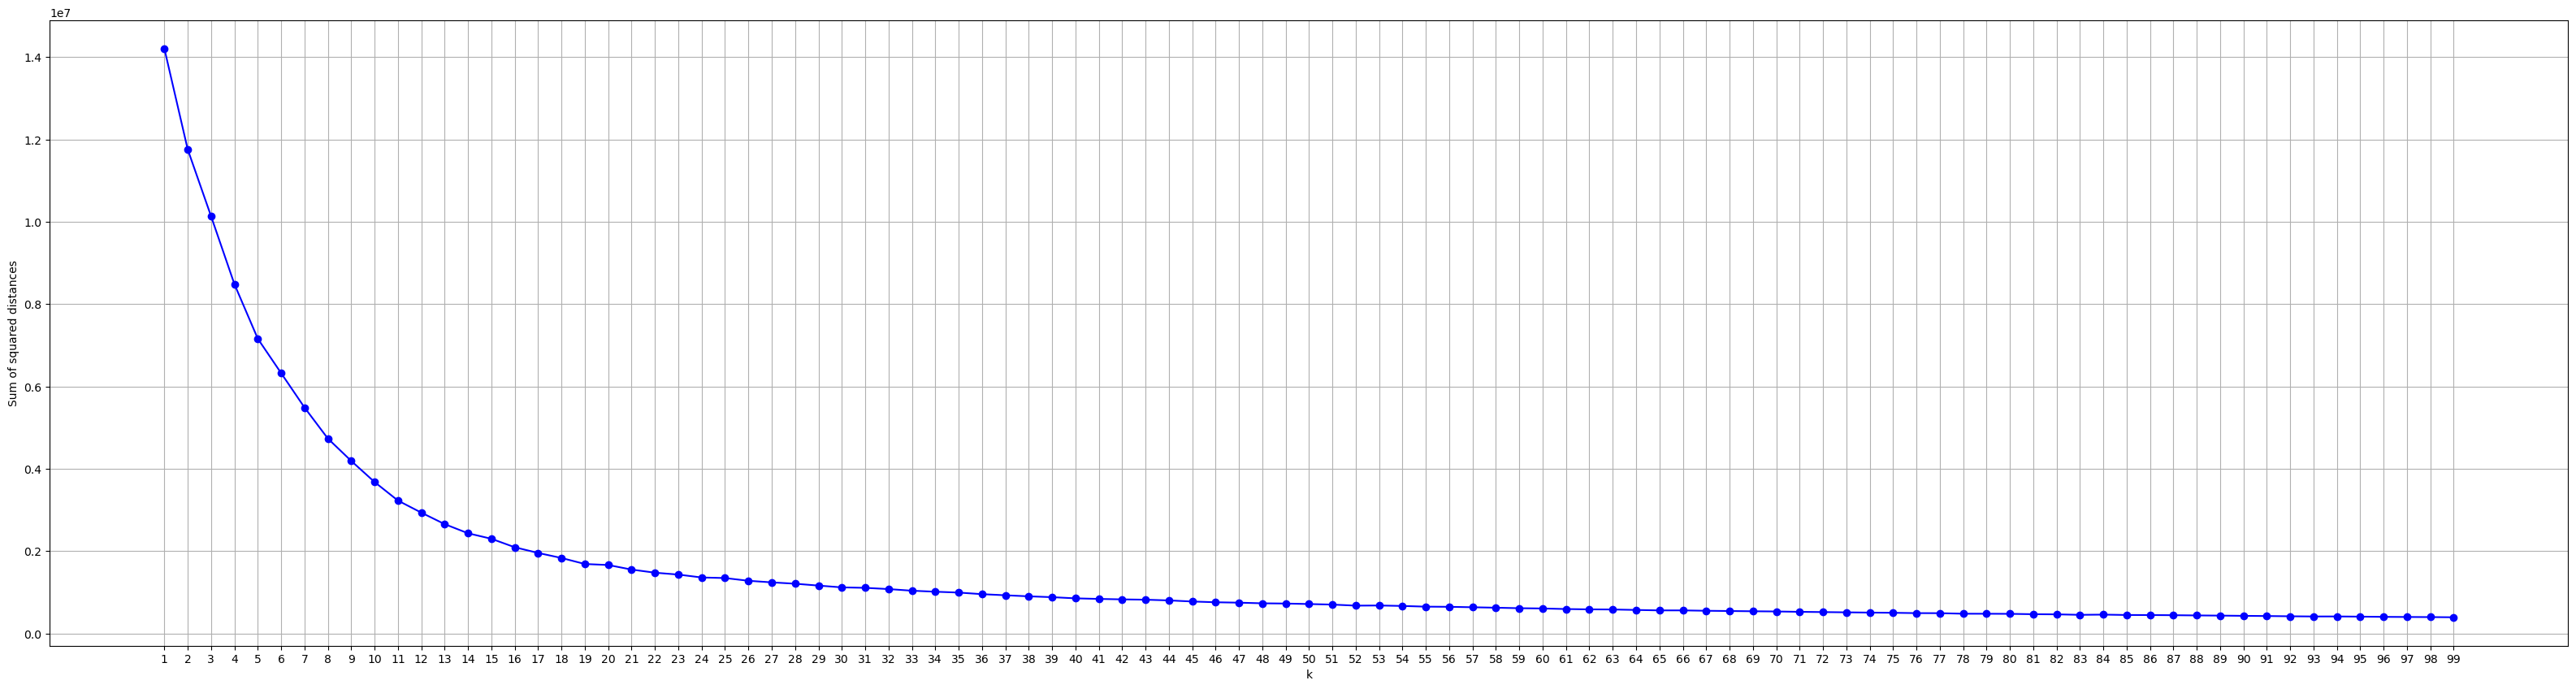

In [109]:
f = plt.figure()
plt.plot(x,y,"bo-",label="Plot 1")     
plt.grid()
plt.ylabel('Sum of squared distances')
plt.xlabel('k')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
f.set_figwidth(40)
f.set_figheight(10)
plt.show()

Looking at the elbow method seems that the best number of cluster that we can obtain is between 2 and 10.  
Let's seek for confirm using the silhouette method.

### Silhouette

The silhouette are a metric useful to understand how a statistical unit is close to the other in his cluster and how far he is from the other that are not in his cluster.
More specifically, if the silhouette score is :
- silhouette score near to 1 : the cluster are very distint
- silhouette score near to 0 : there is overlapping between clusters
- silhouette score is negative : there are some unit that have been assing in the wrong clusters.

#### Average silhouette by sklearn.metrics

Since the silhouette was too hard to computer for the entire dataset we are taking sample.  
We will take 20 different sample with size 50000 unit for each.  
Once that we have all the samples we take the mean and evaluate the final silhouette.

In [47]:
total={}
for i in range(20):
    silhouette={}
    for k in tqdm(range(2, 15)):
        #Set the model
        model = KMeans(n_clusters=k,random_state=30)
        #Get the cluster for each row.
        df_sample=df.sample(50000)
        modello=model.fit_predict(df_sample)
        if k > 1:
            silhouette[k] = silhouette_score(df_sample,modello)
            #silhouette[k] =  silhouette_samples(df,modello)


    #Coordinate for silhouette
    x1=[i for i in silhouette.keys()]
    y1=[silhouette[i] for i in silhouette.keys()]    
    
    total[i]=[x1,y1]

100%|███████████████████████████████████████████| 13/13 [03:42<00:00, 17.09s/it]


In [55]:
a=[]
for i in total.keys():
    a.append(total[i][1])
final_silhouette=np.mean(np.array(a),axis=0)

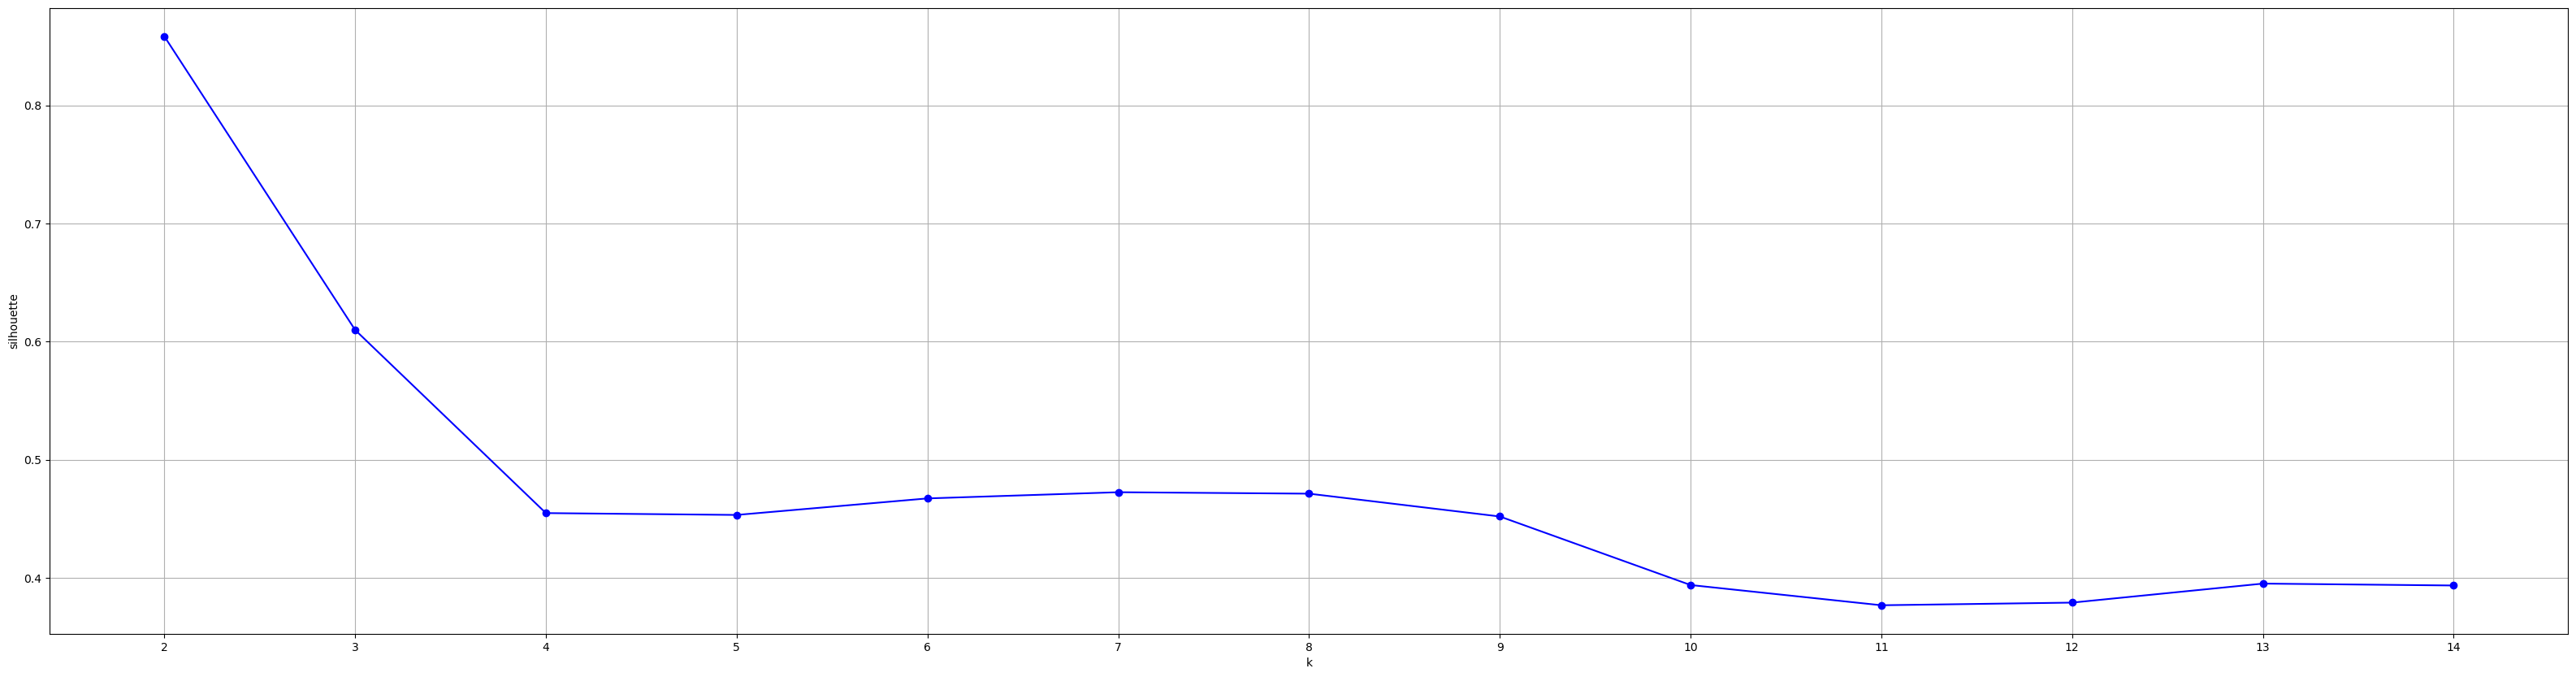

In [62]:
f = plt.figure()

plt.plot(total[0][0],final_silhouette,"bo-",label="Plot 1")     
plt.grid()
plt.ylabel('silhouette')
plt.xlabel('k')
f.set_figwidth(40)
f.set_figheight(10)
plt.xticks(np.arange(min(x1), max(x1)+1, 1.0))
plt.show()

With the analysis of the average silhouette seems that 2 or 3 clusters are very a good choice.    
Altough if we compare the average silhouette with the results of the elbow method it seems that
the cluster are the optimal between 5 and 8.

Let's have a look on the quantity of the clusters.  
It seems that 6th,7th,8th clusters are very small, so in the end we take 5 clusters.

In [18]:
from sklearn.cluster import KMeans
for i in range(5,9):
    try:
        df.drop(columns=["cluster"],inplace=True)
    except:
        pass


    #Set the model
    model = KMeans(n_clusters=i,random_state=30)

    #Get the cluster for each row.
    df["cluster"] = model.fit_predict(df)
    df.head(2)
    print("=======================")
    print(f"{i} clusters")
    print(df.cluster.value_counts()/(df.shape[0])*100)

5 clusters
0    66.873162
1    23.943696
2     7.145556
4     2.025549
3     0.012037
Name: cluster, dtype: float64
6 clusters
0    66.836456
3    23.933923
4     7.140908
1     2.024834
5     0.051842
2     0.012037
Name: cluster, dtype: float64
7 clusters
5    66.559963
1    23.796749
2     6.983593
0     2.076319
6     0.479811
4     0.091529
3     0.012037
Name: cluster, dtype: float64
8 clusters
1    66.295745
0    23.754441
5     7.088112
3     1.974303
6     0.474805
7     0.348834
4     0.051842
2     0.011918
Name: cluster, dtype: float64


## Finally we choose 5 clusters

In [20]:
from sklearn.cluster import KMeans

try:
    df.drop(columns=["cluster"],inplace=True)
except:
    pass


#Set the model
model = KMeans(n_clusters=5,random_state=30)

#Get the cluster for each row.
df["cluster"] = model.fit_predict(df)
df.head(2)

,0,1,2,3,4,5,6,7,cluster
CustomerID,,,,,,,,,
C1010011,0.277082,0.757529,-4.507943,-0.584938,0.962772,-0.033431,0.142159,-1.019176,2
C1010012,-0.265316,-0.019307,0.619049,-0.628901,0.628131,-0.099925,-0.382775,-0.075813,0


### Cluster proportion

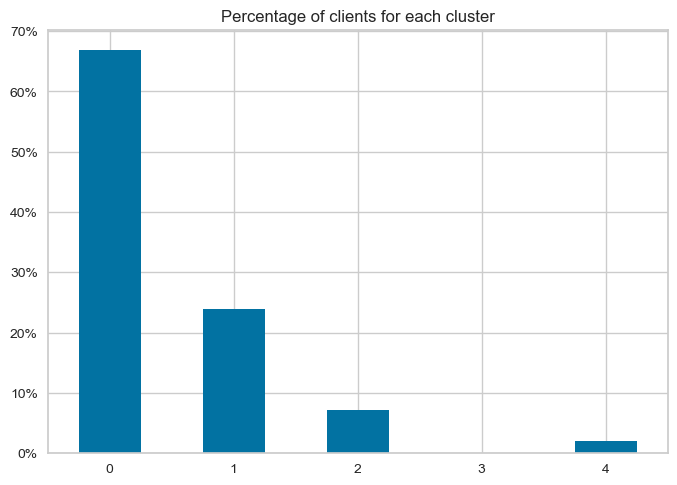

In [21]:
import matplotlib.ticker as mtick
c=pd.DataFrame(df.cluster.value_counts().sort_index())
c["total_percentage"]=c.cluster.apply(lambda x : round(x/sum(c.cluster)*100,2))


ax = c['total_percentage'].plot(kind='bar',rot=0,title='Percentage of clients for each cluster')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

### InterclusterDistance

/opt/anaconda3/envs/hm/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


InterclusterDistance(ax=<AxesSubplot:>, embedding='mds', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

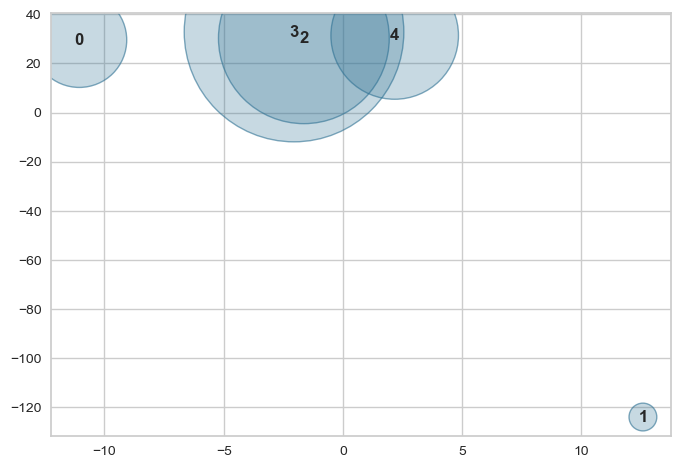

In [23]:
from sklearn.cluster import KMeans
try:
    df.drop(columns=["cluster"],inplace=True)
except:
    pass
#Set the model
model = KMeans(n_clusters=5,random_state=30)

#Get the cluster for each row.
df["cluster"] = model.fit_predict(df)
visualizer = InterclusterDistance(model)
visualizer.fit(df)        # Fit the data to the visualizer

As final think we have a quick look on the InterclusterDistance, altough  because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space we don't give much importance to this metric.

In [13]:
df.cluster.value_counts()/(df.shape[0])*100

1    66.295745
0    23.754441
5     7.088112
3     1.974303
6     0.474805
7     0.348834
4     0.051842
2     0.011918
Name: cluster, dtype: float64

In [24]:
#We store our data in order not to lose them.
df.to_csv("/Users/mattia/Desktop/ADM(Aris)/HM4/clustered_clients.csv")

# 2.4 Analysing your results!

In [65]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

### Import data

In [66]:
df_cluster=pd.read_csv("/Users/mattia/Desktop/ADM(Aris)/HM4/clustered_clients.csv")
df_cluster.head()

,CustomerID,0,1,2,3,4,5,6,7,cluster
0,C1010011,0.277082,0.757529,-4.507943,-0.584938,0.962772,-0.033431,0.142159,-1.019176,2
1,C1010012,-0.265316,-0.019307,0.619049,-0.628901,0.628131,-0.099925,-0.382775,-0.075813,0
2,C1010014,0.317520,0.081817,-4.630823,-0.532873,0.416090,-0.196455,-0.974666,-1.399122,2
3,C1010018,-0.735395,-0.407058,0.560564,2.587314,0.624880,0.137512,1.081094,-0.487843,1
4,C1010024,0.655798,0.906741,0.635878,-0.845409,-1.547964,-0.052474,-0.289689,0.752177,0


Now we merge the datasets by the CustomerID so we will obtain the accounts dataset with the clusters.

In [67]:
df=pd.read_pickle("/Users/mattia/Desktop/ADM(Aris)/HM4/customer28.pkl") 
df.head()

,CustomerID,TOT TransactionAmount (INR),Number_of_transaction,Number_of_transaction_100,Average_transaction_amount,Average_amount_balance,Average_Utilisation,Account_gender,Most_common_location,CustomerAge,Age_in_2016,Major,Old,Min Transaction,Max Transaction,LastAccountBalance,Class_income,Percentual_of_total,Top100,Most_common_day,Percentage_most_common_day,FirstTransactionDate,LastTransactionDate,Percentage_most_common_location,Number_of_transaction_10000,Medium_time_among_transaction,Most_common_hour,Percentage_most_common_hour
0,C1010011,5106.0,2,2.0,2553.0,76340.635,73787.635,FM,NaN,30,24,1,0,356.0,4750.0,32500.73,1,3.653047e-05,0,Monday,100.0,2016-09-08,2016-09-26,NaN,0.0,18 days 00:00:00,NaN,NaN
1,C1010012,1499.0,1,1.0,1499.0,24204.490,22705.490,M,MUMBAI,28,22,1,0,1499.0,1499.0,24204.49,1,2.720559e-05,0,Monday,100.0,2016-08-14,2016-08-14,100.0,0.0,NaN,20,100.0
2,C1010014,1455.0,2,2.0,727.5,100112.950,99385.450,FM,MUMBAI,31,25,1,0,250.0,1205.0,161848.76,2,1.819163e-04,0,Monday,100.0,2016-01-08,2016-07-08,100.0,0.0,182 days 00:00:00,NaN,NaN
3,C1010018,30.0,1,0.0,30.0,496.180,466.180,F,CHAMPARAN,32,27,1,0,30.0,30.0,496.18,0,5.577010e-07,0,Monday,100.0,2016-09-15,2016-09-15,100.0,0.0,NaN,17,100.0
4,C1010024,5000.0,1,1.0,5000.0,87058.650,82058.650,M,KOLKATA,57,52,1,0,5000.0,5000.0,87058.65,1,9.785299e-05,0,Monday,100.0,2016-08-18,2016-08-18,100.0,0.0,NaN,14,100.0


In [68]:
df=pd.merge(df,df_cluster[["CustomerID","cluster"]],on="CustomerID")
df.set_index('CustomerID',inplace=True)
df.head()

,TOT TransactionAmount (INR),Number_of_transaction,Number_of_transaction_100,Average_transaction_amount,Average_amount_balance,Average_Utilisation,Account_gender,Most_common_location,CustomerAge,Age_in_2016,Major,Old,Min Transaction,Max Transaction,LastAccountBalance,Class_income,Percentual_of_total,Top100,Most_common_day,Percentage_most_common_day,FirstTransactionDate,LastTransactionDate,Percentage_most_common_location,Number_of_transaction_10000,Medium_time_among_transaction,Most_common_hour,Percentage_most_common_hour,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C1010011,5106.0,2,2.0,2553.0,76340.635,73787.635,FM,NaN,30,24,1,0,356.0,4750.0,32500.73,1,3.653047e-05,0,Monday,100.0,2016-09-08,2016-09-26,NaN,0.0,18 days 00:00:00,NaN,NaN,2
C1010012,1499.0,1,1.0,1499.0,24204.490,22705.490,M,MUMBAI,28,22,1,0,1499.0,1499.0,24204.49,1,2.720559e-05,0,Monday,100.0,2016-08-14,2016-08-14,100.0,0.0,NaN,20,100.0,0
C1010014,1455.0,2,2.0,727.5,100112.950,99385.450,FM,MUMBAI,31,25,1,0,250.0,1205.0,161848.76,2,1.819163e-04,0,Monday,100.0,2016-01-08,2016-07-08,100.0,0.0,182 days 00:00:00,NaN,NaN,2
C1010018,30.0,1,0.0,30.0,496.180,466.180,F,CHAMPARAN,32,27,1,0,30.0,30.0,496.18,0,5.577010e-07,0,Monday,100.0,2016-09-15,2016-09-15,100.0,0.0,NaN,17,100.0,1
C1010024,5000.0,1,1.0,5000.0,87058.650,82058.650,M,KOLKATA,57,52,1,0,5000.0,5000.0,87058.65,1,9.785299e-05,0,Monday,100.0,2016-08-18,2016-08-18,100.0,0.0,NaN,14,100.0,0


Now that we have our final dataset we will procede with the analysis.

## Identify the cluster

### Select the features that are relevant for identify the clusters

With this table we are able to have a quick look on all numerical features in the clusters.

In [69]:
df.groupby("cluster").describe()

TOT TransactionAmount (INR)                                       \
                              count          mean           std      min   
cluster                                                                    
0                          561120.0    978.389864   1486.329283     0.00   
1                          200907.0   1102.014714   1543.581526     0.00   
2                           59957.0   2758.158713   3538.955699     4.00   
3                             101.0   9717.467525  23638.241573   131.35   
4                           16996.0  29086.695410  35829.516010  2062.00   

                                                Number_of_transaction  \
             25%      50%       75%         max                 count   
cluster                                                                 
0          156.0    440.0   1100.00    18595.00              561120.0   
1          200.0    509.0   1348.00    16210.00              200907.0   
2          729.0   1543.0   3176.32    39602.75               59957.0   
3         1479.0   2800.0   5476.00   143961.00                 101.0   
4        13600.0  20000.0  30702.00  1560034.99               16996.0   

                                                      \
             mean       std  min  25%  50%  75%  max   
cluster                                                
0        1.103808  0.308544  1.0  1.0  1.0  1.0  3.0   
1        1.042736  0.202803  1.0  1.0  1.0  1.0  3.0   
2        2.273479  0.504876  2.0  2.0  2.0  2.0  6.0   
3        1.237624  0.450522  1.0  1.0  1.0  1.0  3.0   
4        1.178160  0.432467  1.0  1.0  1.0  1.0  5.0   

        Number_of_transaction_100                                          \
                            count      mean       std  min  25%  50%  75%   
cluster                                                                     
0                        561120.0  0.865790  0.490771  0.0  1.0  1.0  1.0   
1                        200907.0  0.869208  0.415738  0.0  1.0  1.0  1.0   
2                         59957.0  1.860083  0.705752  0.0  1.0  2.0  2.0   
3                           101.0  1.207921  0.431667  1.0  1.0  1.0  1.0   
4                         16996.0  1.139092  0.379156  1.0  1.0  1.0  1.0   

             Average_transaction_amount                                       \
         max                      count          mean           std      min   
cluster                                                                        
0        2.0                   561120.0    886.012084   1345.862337     0.00   
1        2.0                   200907.0   1056.437260   1476.704056     0.00   
2        6.0                    59957.0   1218.269685   1555.196590     2.00   
3        3.0                      101.0   8732.695809  23190.935247   126.71   
4        4.0                    16996.0  25675.298905  33275.532033  2062.00   

                                                             \
                  25%           50%         75%         max   
cluster                                                       
0          150.000000    400.000000   1000.0000    10020.00   
1          200.000000    500.000000   1289.0000    10800.00   
2          332.716667    680.316667   1390.0000    11999.50   
3         1368.000000   2254.000000   4500.0000   143961.00   
4        12543.000000  17250.000000  26923.2525  1560034.99   

        Average_amount_balance                                            \
                         count          mean           std           min   
cluster                                                                    
0                     561120.0  9.619335e+04  4.812682e+05  0.000000e+00   
1                     200907.0  9.061923e+04  3.729448e+05  0.000000e+00   
2                      59957.0  1.010602e+05  3.649124e+05  0.000000e+00   
3                        101.0  4.975331e+07  2.722940e+07  1.252693e+07   
4                      16996.0  3.267903e+05  1.301639e+06  0.000000e+

It seems that all the following features are different between the clusters:
- TOT TransactionAmount (INR) (numerical)
- Average_transaction_amount  (numerical)
- Class income                (numerical)
- Customer age                (numerical)
- Min transaction             (numerical) 
- Max transaction             (numerical)

Also we check the gender features:

In [70]:
df.groupby("cluster")["Account_gender"].value_counts()

cluster  Account_gender
0        M                 561120
1        F                 200907
2        FM                 53785
         M                   5778
         F                    394
3        M                     78
         F                     18
         FM                     5
4        M                  11660
         F                   4425
         FM                   911
Name: Account_gender, dtype: int64

It seems that   gender feature assume different distribution among clusters.

### Built the classes for the numerical features

#### "TOT TransactionAmount (INR)"

In order to create better classes we look the quantile and the mean of the distribution. 

In [71]:
df["TOT TransactionAmount (INR)"].describe().apply(lambda x: '%.2f' % x)

count     839081.00
mean        1705.56
std         6687.66
min            0.00
25%          198.00
50%          500.00
75%         1418.00
max      1560034.99
Name: TOT TransactionAmount (INR), dtype: object

The classes will be:
Class , range:
- Lower 0,     [0,500)
- Medium 1,    [500,2000)
- High 2,   [2000,10000)
- Very High 3,[10000,inf)

In [72]:
df["TOT TransactionAmount (INR) CLASS"]=0
df.loc[(df["TOT TransactionAmount (INR)"] >= 500 )& (df["TOT TransactionAmount (INR)"] < 2000 ),"TOT TransactionAmount (INR) CLASS"]=1
df.loc[(df["TOT TransactionAmount (INR)"] >= 2000 )& (df["TOT TransactionAmount (INR)"] < 10000 ),"TOT TransactionAmount (INR) CLASS"]=2
df.loc[(df["TOT TransactionAmount (INR)"] >=10000 ),"TOT TransactionAmount (INR) CLASS"]=3

Let's have a look at the classes.

In [73]:
df["TOT TransactionAmount (INR) CLASS"].value_counts()

0    401296
1    285806
2    129912
3     22067
Name: TOT TransactionAmount (INR) CLASS, dtype: int64

It seems that the class are balanced.

#### Average_transaction_amount

Since this feature is pretty similar to the previous one we will use the same classes.

In [74]:
df["Average_transaction_amount"].describe().apply(lambda x: '%.2f' % x)

count     839081.00
mean        1453.62
std         6045.20
min            0.00
25%          180.00
50%          475.00
75%         1175.73
max      1560034.99
Name: Average_transaction_amount, dtype: object

The classes will be:
Class , range:
- Lower 0,     [0,500)
- Medium 1,    [500,2000)
- High 2,   [2000,10000)
- Very High 3,[10000,inf)

In [75]:
df["Average_transaction_amount_class"]=0
df.loc[(df["Average_transaction_amount"] >= 500 )& (df["Average_transaction_amount"] < 2000 ),"Average_transaction_amount_class"]=1
df.loc[(df["Average_transaction_amount"] >= 2000 )& (df["Average_transaction_amount"] < 10000 ),"Average_transaction_amount_class"]=2
df.loc[(df["Average_transaction_amount"] >=10000 ),"Average_transaction_amount_class"]=3

In [76]:
df["Average_transaction_amount_class"].value_counts()

0    429821
1    284295
2    107077
3     17888
Name: Average_transaction_amount_class, dtype: int64

#### Class income

This feature is already in class form.

#### Customer age (Age_in_2016)

The classes will be:
Class , range:
- minor 0,     [0,18)
- young 1,    [18,25)
- workers 2,   [25,65)
- pensioners 3,[65,inf)

In [77]:
df["Age_in_2016_class"]=0
df.loc[(df["Age_in_2016"] >= 18 )& (df["Age_in_2016"] < 25 ),"Age_in_2016_class"]=1
df.loc[(df["Age_in_2016"] >= 25 )& (df["Age_in_2016"] < 65 ),"Age_in_2016_class"]=2
df.loc[(df["Age_in_2016"] >= 65 ),"Age_in_2016_class"]=3

In [78]:
df["Age_in_2016_class"].value_counts()

2    690864
1    139644
3      8138
0       435
Name: Age_in_2016_class, dtype: int64

In [79]:
##

In [80]:
df.columns

Index(['TOT TransactionAmount (INR)', 'Number_of_transaction',
       'Number_of_transaction_100', 'Average_transaction_amount',
       'Average_amount_balance', 'Average_Utilisation', 'Account_gender',
       'Most_common_location', 'CustomerAge', 'Age_in_2016', 'Major', 'Old',
       'Min Transaction', 'Max Transaction', 'LastAccountBalance',
       'Class_income', 'Percentual_of_total', 'Top100', 'Most_common_day',
       'Percentage_most_common_day', 'FirstTransactionDate',
       'LastTransactionDate', 'Percentage_most_common_location',
       'Number_of_transaction_10000', 'Medium_time_among_transaction',
       'Most_common_hour', 'Percentage_most_common_hour', 'cluster',
       'TOT TransactionAmount (INR) CLASS', 'Average_transaction_amount_class',
       'Age_in_2016_class'],
      dtype='object')

## Pivot tables

### Pivot tables for Account_gender

In [84]:
table = pd.pivot_table(df, index=['cluster'],aggfunc={'Account_gender': 'count',},columns='Account_gender').fillna(0)
table

Account_gender                   
Account_gender              F       FM         M
cluster                                         
0                         0.0      0.0  561120.0
1                    200907.0      0.0       0.0
2                       394.0  53785.0    5778.0
3                        18.0      5.0      78.0
4                      4425.0    911.0   11660.0

### Pivot tables for tot transaction amount

In [85]:
table = pd.pivot_table(df, index=['cluster'],aggfunc={"TOT TransactionAmount (INR) CLASS": 'count',},columns="TOT TransactionAmount (INR) CLASS").fillna(0)
table

TOT TransactionAmount (INR) CLASS            \
TOT TransactionAmount (INR) CLASS                                 0         1   
cluster                                                                         
0                                                          296111.0  187002.0   
1                                                           95851.0   72583.0   
2                                                            9324.0   26196.0   
3                                                              10.0      25.0   
4                                                               0.0       0.0   

                                                     
TOT TransactionAmount (INR) CLASS        2        3  
cluster                                              
0                                  76663.0   1344.0  
1                                  31972.0    501.0  
2                                  21218.0   3219.0  
3                                     50.0     16.0  
4                                      9.0  16987.0

### Pivot tables for "Average_transaction_amount_class"

In [89]:
table = pd.pivot_table(df, index=['cluster'],aggfunc={"Average_transaction_amount_class": 'count'},columns="Average_transaction_amount_class").fillna(0)
table

Average_transaction_amount_class            \
Average_transaction_amount_class                                0         1   
cluster                                                                       
0                                                        309359.0  184004.0   
1                                                         97578.0   72713.0   
2                                                         22871.0   27549.0   
3                                                            13.0      29.0   
4                                                             0.0       0.0   

                                                    
Average_transaction_amount_class        2        3  
cluster                                             
0                                 67015.0    742.0  
1                                 30229.0    387.0  
2                                  9372.0    165.0  
3                                    44.0     15.0  
4                                   417.0  16579.0

### Pivot tables for Class_income

In [90]:
table = pd.pivot_table(df, index=['cluster'],aggfunc={"Class_income": 'count'},columns="Class_income").fillna(0)
table

Class_income                           
Class_income            0         1        2       3
cluster                                             
0                232395.0  245052.0  74786.0  8887.0
1                 67984.0   97844.0  32598.0  2481.0
2                 22636.0   27267.0   9132.0   922.0
3                     0.0       0.0      0.0   101.0
4                  3332.0    7159.0   5452.0  1053.0

### Pivot tables for age

In [92]:
table = pd.pivot_table(df, index=['cluster'],aggfunc={"Age_in_2016_class": 'count'},columns="Age_in_2016_class").fillna(0)
table

Age_in_2016_class                           
Age_in_2016_class                 0        1         2       3
cluster                                                       
0                             307.0  89603.0  466371.0  4839.0
1                              81.0  38416.0  160329.0  2081.0
2                              38.0  10253.0   49024.0   642.0
3                               0.0      1.0      81.0    19.0
4                               9.0   1371.0   15059.0   557.0

## Percentage by column for each pivot table

### Gender account

In [120]:
pd.crosstab(df.cluster,df.Account_gender).apply(lambda r: r/r.sum()*100, axis=1)

Account_gender,F,FM,M
cluster,,,
0,0.000000,0.000000,100.000000
1,100.000000,0.000000,0.000000
2,0.657138,89.705956,9.636906
3,17.821782,4.950495,77.227723
4,26.035538,5.360085,68.604378


### Tot transaction amount

In [122]:
pd.crosstab(df.cluster,df["TOT TransactionAmount (INR) CLASS"]).apply(lambda r: r/r.sum()*100, axis=1)

TOT TransactionAmount (INR) CLASS,0,1,2,3
cluster,,,,
0,52.771421,33.326561,13.662496,0.239521
1,47.709139,36.127661,15.913831,0.249369
2,15.551145,43.691312,35.388695,5.368848
3,9.900990,24.752475,49.504950,15.841584
4,0.000000,0.000000,0.052954,99.947046


### Average_transaction_amount_class

In [123]:
pd.crosstab(df.cluster,df.Average_transaction_amount_class).apply(lambda r: r/r.sum()*100, axis=1)

Average_transaction_amount_class,0,1,2,3
cluster,,,,
0,55.132414,32.792273,11.943078,0.132236
1,48.568741,36.192368,15.046265,0.192626
2,38.145671,45.947929,15.631202,0.275197
3,12.871287,28.712871,43.564356,14.851485
4,0.000000,0.000000,2.453518,97.546482


### Class_income

In [124]:
pd.crosstab(df.cluster,df.Class_income).apply(lambda r: r/r.sum()*100, axis=1)

Class_income,0,1,2,3
cluster,,,,
0,41.416275,43.671942,13.327987,1.583797
1,33.838542,48.701140,16.225418,1.234900
2,37.753724,45.477592,15.230915,1.537769
3,0.000000,0.000000,0.000000,100.000000
4,19.604613,42.121676,32.078136,6.195575


### Age

In [125]:
pd.crosstab(df.cluster,df.Age_in_2016_class).apply(lambda r: r/r.sum()*100, axis=1)

Age_in_2016_class,0,1,2,3
cluster,,,,
0,0.054712,15.968599,83.114307,0.862382
1,0.040317,19.121285,79.802595,1.035803
2,0.063379,17.100589,81.765265,1.070767
3,0.000000,0.990099,80.198020,18.811881
4,0.052954,8.066604,88.603201,3.277242


# Clusters report

| cluster  | size  |  About gender | about how much they have  | about average transactions   |  about age |
|---|---|---|---|---|---|
| 0 | 561120| only men  |  substanial equality between low and medium clients|  most of standard and lower transaction |   |
| 1 |  200907| only women  | 48% have  between [10.000,100.000) INR | most of standard and lower transaction  |   |
| 2 | 59957|  most of mixed account 89% (men ad women) |  substanial equality between low and medium clients | most of standard and lower transaction  |   |
| 3 |  101|  77% of men |  100% have more than 1.000.000 INR | 43% of transaction between [2000,10000) INR and 14% of transaction highier than 10.000 INR  | 18% of pensioners  |
| 4 | 16996|  68% of men  | 32% have  between [100.000,1.000.000) INR  |  97% have done transaction highier than 10.000 INR  |   |


- All the clusters have around 80% of people between 25 and 65.   
- Clusters 0,1,2 have around 15% of accounts that have money between [100.000,1.000.000) INR.   
- Clusters 0,1,2 have around 15% of accounts that have done transaction between [2000,10000) INR.   



We can conclude that the 3th and the 4th cluster are made up of the richest accounts.   
While 0,1,2 clusters are made up mostly of standards accounts.

**Note:**   
A reminder of average transactions classes:  
- Lower 0,     [0,500)
- Medium 1,    [500,2000)
- High 2,   [2000,10000)
- Very High 3,[10000,inf)


# Algorithmic Question

First of all we take as input ***n*** the number of entrances, ***m*** the number of students and ***g*** the number of the guards.

In [6]:
n, m, g = map(int,input().split())

2 5 1


Then we can take as input m integers that correspond to the number of the entrances in which each students should enter.    
We store these number as a list called ***students***.

In [7]:
students = list(map(int,input().split()))

1 2 1 2 2


We can now create a function that return ***'YES'*** if the number of guards taken as input is enough or ***'NO'*** otherwise.   
The idea is to create an empty list ***open*** in which we can everytime append the number of the open entrance.

In [3]:
def enough_guard(students,m,g):
    open = []
    # for every element students[i] in students
    for i in range(m):
        # if the door students[i] is already open and the door is present also in the 'last' elements of the list we can skip the for loop
        if students[i] in open and students[i] in students[i+1:]:
            continue
        # if the door students[i] is already open and it isn't present in the 'last' element of the list this mean that we can close that door.
        # So we can delete from open the element students[i] and add 1 to the number of the guards available
        elif students[i] in open and students[i] not in students[i+1:]:
            g += 1
            open.remove(students[i])
            continue
        # if the door students[i] isn't already open and it's also present in the 'last' elements of the list students and if the number of guards is greater than 0
        # then we can add the number of the door to the list open and take away a guard from the number of available guards
        # instead if g<=0 these mean that g guards are not enough 
        elif students[i] not in open and students[i] in students[i+1:]:
            if g >0:
                open.append(students[i])
                g -= 1
                continue
            else:
                return 'NO'
        # if students[i] is not already open but also it's not present in the 'last' part of the list this mean that in that entrance should enter just one student
        # so we can check if there is a guard available. If not this means that the number of guards g is not enough
        elif students[i] not in open and students[i] not in students[i+1:]:
            if g>0:
                continue
            else:
                return 'NO'

    return 'YES'


In [8]:
YES_or_NO = enough_guard(students,m,g)     

Output with as input:   
4 5 1  
1 1 3 3 3

In [5]:
print(YES_or_NO)

YES


Output with as input:   
2 5 1    
1 2 1 2 2

In [9]:
print(YES_or_NO)

NO
